# Project 1 - Gender Classification w GoogleNet


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import pandas as pd
import os
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, classification_report


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class GenderDataset(Dataset):
    def __init__(self, df_attributes, image_folder, transform=None):
        self.df = df_attributes
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx, 0]  # kolom pertama adalah filename
        image_path = os.path.join(self.image_folder, filename)
        image = Image.open(image_path).convert('RGB')

        # Kolom Male ada di index 21 (0-indexed) berdasarkan list_attribute.txt
        male_label = self.df.iloc[idx, 21]
        label = 1 if male_label == 1 else 0  # 1 untuk Male, 0 untuk Female

        # Convert ke tensor
        image = transforms.ToTensor()(image)

        return image, label

In [4]:
image_folder = '/content/drive/MyDrive/Dataset-CV/Gender_Classification/Images'
attribute_path = '/content/drive/MyDrive/Dataset-CV/Gender_Classification/list_attribute.txt'

In [5]:
with open(attribute_path, 'r') as f:
    lines = f.readlines()

In [6]:
header = lines[1].strip().split()
data_lines = lines[2:]

In [7]:
header

['5_o_Clock_Shadow',
 'Arched_Eyebrows',
 'Attractive',
 'Bags_Under_Eyes',
 'Bald',
 'Bangs',
 'Big_Lips',
 'Big_Nose',
 'Black_Hair',
 'Blond_Hair',
 'Blurry',
 'Brown_Hair',
 'Bushy_Eyebrows',
 'Chubby',
 'Double_Chin',
 'Eyeglasses',
 'Goatee',
 'Gray_Hair',
 'Heavy_Makeup',
 'High_Cheekbones',
 'Male',
 'Mouth_Slightly_Open',
 'Mustache',
 'Narrow_Eyes',
 'No_Beard',
 'Oval_Face',
 'Pale_Skin',
 'Pointy_Nose',
 'Receding_Hairline',
 'Rosy_Cheeks',
 'Sideburns',
 'Smiling',
 'Straight_Hair',
 'Wavy_Hair',
 'Wearing_Earrings',
 'Wearing_Hat',
 'Wearing_Lipstick',
 'Wearing_Necklace',
 'Wearing_Necktie',
 'Young']

In [8]:
data_lines[0]

'000001.jpg -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1  1 -1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1 -1  1\n'

In [9]:
# Parsing data di list_attribute.txt
data = []
for line in data_lines:
    parts = line.strip().split()
    filename = parts[0]
    attributes = [int(x) for x in parts[1:]]
    data.append([filename] + attributes)

columns = ['filename'] + header
df_attributes = pd.DataFrame(data, columns=columns)

# Filter gambar yang ditemukan di image folder dan `filename` dari df_attributes
existing_files = []
for idx, row in df_attributes.iterrows():
    filename = row['filename']
    image_path = os.path.join(image_folder, filename)
    if os.path.exists(image_path):
        existing_files.append(idx)

df_attributes = df_attributes.iloc[existing_files].reset_index(drop=True) # Filter berdasarkan existing_files, reset index dan buang index lama

print(f"Total samples: {len(df_attributes)}")
print(f"Male count: {(df_attributes['Male'] == 1).sum()}")
print(f"Female count: {(df_attributes['Male'] == -1).sum()}")

Total samples: 5000
Male count: 2047
Female count: 2953


In [10]:
df_attributes.head()

,filename,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000051.jpg,1,-1,-1,1,1,-1,-1,1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,000052.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,-1
2,000065.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,...,-1,1,1,-1,-1,-1,-1,-1,-1,1
3,000166.jpg,1,-1,-1,-1,-1,-1,-1,1,-1,...,1,-1,-1,-1,-1,1,-1,-1,-1,-1
4,000198.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [11]:
# Generate dataset
dataset = GenderDataset(df_attributes, image_folder, transform=None)

# Split train-test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [12]:
# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
# Pretrained googlenet
model = models.googlenet(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # 2 classes: Male, Female

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 144MB/s]


In [14]:
# Loss dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
print(f"Using device: {device}")
print("Starting training...")

train_loss = []
train_acc = []
test_loss = []
test_acc = []

# Training
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        # Adam Optimizer Gradien
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}], Loss: {loss.item():.4f}')

    epoch_acc = 100 * correct / total
    epoch_loss = running_loss / len(train_loader)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)

    # Evaluasi per epoch
    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_epoch_acc = 100 * test_correct / test_total
    test_epoch_loss = test_running_loss / len(test_loader)
    test_loss.append(test_epoch_loss)
    test_acc.append(test_epoch_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%, Test Loss: {test_epoch_loss:.4f}, Test Accuracy: {test_epoch_acc:.2f}%')

print("Training completed!")

# Testing
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Metrik testing
test_accuracy = 100 * correct / total
print(f'\nTest Accuracy: {test_accuracy:.2f}%')

# Classification report
class_names = ['Female', 'Male']
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=class_names))

print("Model evaluation completed!")

Using device: cuda
Starting training...
Epoch [1/10], Batch [0], Loss: 0.6988
Epoch [1/10], Batch [100], Loss: 0.1264
Epoch [1/10] - Train Loss: 0.1907, Train Accuracy: 91.83%, Test Loss: 0.4179, Test Accuracy: 81.30%
Epoch [2/10], Batch [0], Loss: 0.0925
Epoch [2/10], Batch [100], Loss: 0.1813
Epoch [2/10] - Train Loss: 0.0935, Train Accuracy: 96.35%, Test Loss: 0.2011, Test Accuracy: 90.60%
Epoch [3/10], Batch [0], Loss: 0.2057
Epoch [3/10], Batch [100], Loss: 0.5417
Epoch [3/10] - Train Loss: 0.0881, Train Accuracy: 96.83%, Test Loss: 0.1001, Test Accuracy: 96.10%
Epoch [4/10], Batch [0], Loss: 0.0151
Epoch [4/10], Batch [100], Loss: 0.0388
Epoch [4/10] - Train Loss: 0.0473, Train Accuracy: 98.20%, Test Loss: 0.6525, Test Accuracy: 85.00%
Epoch [5/10], Batch [0], Loss: 0.2986
Epoch [5/10], Batch [100], Loss: 0.0145
Epoch [5/10] - Train Loss: 0.0422, Train Accuracy: 98.47%, Test Loss: 0.1587, Test Accuracy: 94.60%
Epoch [6/10], Batch [0], Loss: 0.0053
Epoch [6/10], Batch [100], Loss:

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Kelupaan

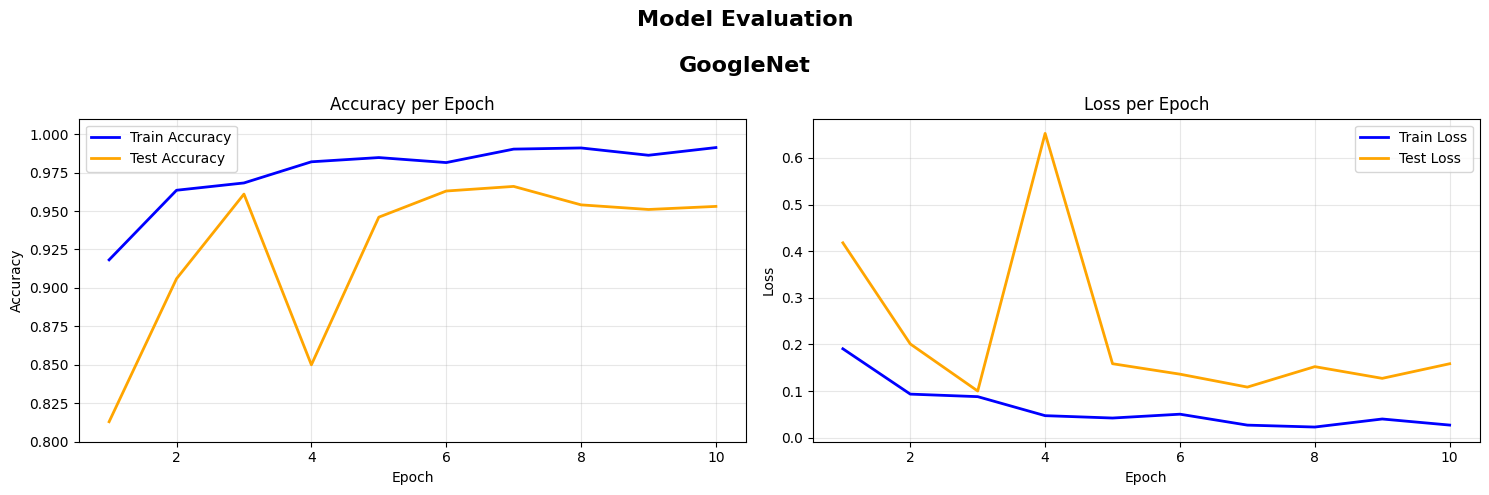

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(1, num_epochs + 1)
ax1.plot(epochs, [acc/100 for acc in train_acc], 'b-', label='Train Accuracy', linewidth=2)
ax1.plot(epochs, [acc/100 for acc in test_acc], 'orange', label='Test Accuracy', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy per Epoch')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0.8, 1.01) # Batas bawah diganti ke 0.8

ax2.plot(epochs, train_loss, 'b-', label='Train Loss', linewidth=2)
ax2.plot(epochs, test_loss, 'orange', label='Test Loss', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Loss per Epoch')
ax2.legend()
ax2.grid(True, alpha=0.3)

fig.suptitle('Model Evaluation\n\nGoogleNet', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

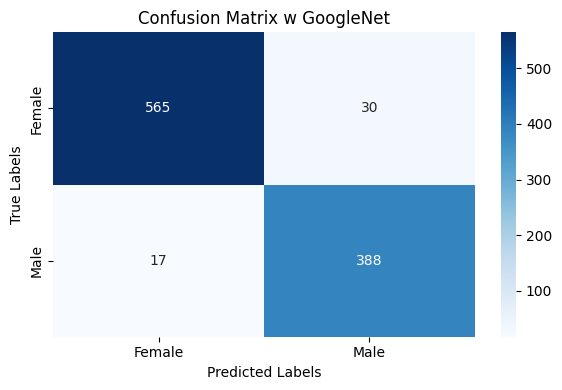

In [18]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix w GoogleNet')
plt.tight_layout()
plt.show()
